TG-AI

# **진단검사 결과 검체뒤바뀜 오류 감지**

세부 목표

1. Clinical Tabular DB 다루기

2. 진단검사 내 오류 감지 모델 개발

3. 하이퍼파라미터 튜닝

In [ ]:
!git clone https://github.com/dlab-amc/DLab-TG-AI.git

In [ ]:
dir_path = '/content/DLab-TG-AI/'

In [ ]:
import pandas as pd

df_raw=pd.read_csv(dir_path+'competition_data.csv')
display(df_raw)
print('Patient num: ',df_raw['환자번호'].value_counts().shape)

df_raw['검사일'] = pd.to_datetime(df_raw['검사일'], errors='coerce')
date_to_remove = pd.to_datetime('2024-11-01').date()
df_filtered = df_raw[df_raw['검사일'].dt.date != date_to_remove]
df_filtered['검사일'].value_counts()
# 24 10 29-31
import numpy as np
start_date = pd.to_datetime('2024-10-29').date()
end_date = pd.to_datetime('2024-10-31').date()
df_filtered_test = df_raw[df_raw['검사일'].dt.date.between(start_date, end_date)]
# 1. 데이터 피벗팅 (pivot_table)
df_pivot = df_filtered_test.pivot_table(
    index=['검체번호', '검사일', '환자번호', '성별', '나이', '진료과', '입원/외래'],  # 고정할 인덱스 열
    columns='검사항목',  # 피벗팅할 열
    values='결과',  # 피벗된 열의 값으로 사용할 데이터
    aggfunc='first'  # 중복된 값이 있을 경우 첫 번째 값 사용
).reset_index()  # 결과를 데이터프레임으로 반환

print('### 피벗팅 결과')
display(df_pivot)  # 피벗 결과 확인

# 2. '환자번호'와 '검사일' 기준으로 데이터 정렬
df_pivot.sort_values(['환자번호', '검사일'], inplace=True)

# 3. '환자번호' 기준으로 그룹화
grouped = df_pivot.groupby('환자번호')

# 4. 그룹 내에서 이전 행 데이터를 가져옴
previous_results = grouped.shift(1)  # 각 그룹의 이전 행을 가져옴
previous_results.columns = ['prev_' + str(col) for col in previous_results.columns]  # 열 이름에 'prev_' 접두사 추가

# 5. 현재 결과(df_pivot)와 이전 결과(previous_results)를 합침
final_df = pd.concat([df_pivot, previous_results], axis=1).reset_index(drop=True)  # 두 데이터프레임을 열 방향으로 합침

print('### 현재결과 및 직전결과로 구성을 변형한 결과')
display(final_df)  # 최종 데이터프레임 확인

# 6. 결측치 제거 (이전 결과가 없는 첫 행 등)
df_input = final_df.dropna()  # NaN이 포함된 행 제거

print('### 의미없는 직전결과는 제외한 결과')
display(df_input)  # 최종 데이터프레임 확인

# 7. 최종 데이터프레임의 열 이름 출력
print(df_input.columns)

tdf_input = df_input.copy()
tdf_input.columns
tdf_input=tdf_input.convert_dtypes()
tdf_input.dtypes
tdf_input

# 성별 및 입원/외래 에 해당하는 변수 변환
tdf_input.loc[:,'성별']=tdf_input['성별'].astype(str).map({'M':1,'F':2})
tdf_input.loc[:,'prev_성별']=tdf_input['prev_성별'].astype(str).map({'M':1,'F':2})
tdf_input.loc[:,'입원/외래']=tdf_input['입원/외래'].astype(str).map({'입원':1,'외래':2})
tdf_input.loc[:,'prev_입원/외래']=tdf_input['prev_입원/외래'].astype(str).map({'입원':1,'외래':2})

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder() # LabelEncoder 인스턴스를 생성합니다
tdf_input.loc[:,'진료과'] = tdf_input['진료과'].astype(str)
tdf_input.loc[:,'prev_진료과'] = tdf_input['prev_진료과'].astype(str)

# '진료과' 및 'prev_진료과' 열의 모든 고유 값들을 하나의 시리즈로 결합하고, NaN 값을 제거한 후 고유한 값들만 추출합니다
all_departments = pd.concat([tdf_input['진료과'], tdf_input['prev_진료과']]).dropna().unique()
# LabelEncoder를 사용하여 모든 진료과의 데이터에 대해 숫자형 레이블로 변환을 학습 (fit)
encoder.fit(all_departments)
tdf_input.loc[:,'진료과'] = encoder.transform(tdf_input['진료과']) # 학습된 결과를 그대로 적용 transform
tdf_input.loc[:,'prev_진료과'] = encoder.transform(tdf_input['prev_진료과'])

import re
def extract_number(value):
    # 정규 표현식을 사용하여 문자열에서 숫자만 추출
    match = re.search(r'\d+(\.\d+)?', str(value))
    if match:
        return float(match.group())
    return None

sel_col = ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein','prev_ALP',
       'prev_ALT', 'prev_AST', 'prev_Albumin', 'prev_BUN', 'prev_Creatinine',
       'prev_GGT', 'prev_Glucose', 'prev_LDH', 'prev_Total Bilirubin',
       'prev_Total Protein']

for col in sel_col:
    tdf_input[col] = tdf_input[col].apply(extract_number)
tdf_input.dtypes

x=tdf_input[['검체번호','환자번호','검사일','성별','나이','진료과','입원/외래','ALP', 'ALT', 'AST',
       'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH',
       'Total Bilirubin', 'Total Protein','prev_나이', 'prev_진료과', 'prev_입원/외래', 'prev_ALP', 'prev_ALT', 'prev_AST',
       'prev_Albumin', 'prev_BUN', 'prev_Creatinine', 'prev_GGT',
       'prev_Glucose', 'prev_LDH', 'prev_Total Bilirubin',
       'prev_Total Protein']]
x = x.reset_index(drop=True)
# 실제 사용할 변수들 한정해서 input dataset 구성
def shuffle_selected_columns_together_df(df, columns, shuffle_ratio, random_state=None):
    """
    Shuffles entire rows of the selected columns in the input DataFrame based on the specified shuffle ratio.

    Args:
    df (pandas.DataFrame): The input data DataFrame to be shuffled.
    columns (list of str or int): List of column names or indices to shuffle together.
    shuffle_ratio (float): The fraction of the rows to shuffle (0 < shuffle_ratio <= 1).
    random_state (int, optional): A seed number to make the shuffle deterministic. Default is None.

    Returns:
    pandas.DataFrame: The shuffled DataFrame.
    numpy.array: An indicator array where shuffled rows are marked as 1 and others as 0.
    """
    arr = df.copy()
    rng = np.random.RandomState(random_state)
    num_rows_to_shuffle = int(arr.shape[0] * shuffle_ratio)
    shuffle_indices = rng.permutation(arr.shape[0])[:num_rows_to_shuffle]

    selected_data = arr.loc[shuffle_indices, columns]
    selected_data = selected_data.sample(frac=1, random_state=random_state)
    arr.loc[shuffle_indices, columns] = selected_data.values

    shuffle_indicator = np.zeros(arr.shape[0], dtype=int)
    shuffle_indicator[shuffle_indices] = 1

    return arr, shuffle_indicator

x_total,y_total=shuffle_selected_columns_together_df(x, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.1, random_state=111)
display(x_total)
x_total.to_csv(dir_path+'evaluation_set.csv', index=False)
pd.DataFrame(y_total, columns=['Label']).to_csv(dir_path+'evaluation_label.csv', index=False)


,검체번호,검사일,환자번호,성별,나이,검사항목,결과,진료과,입원/외래
0,H8XGOUY1S,2024-10-10 14:54:53,Z6GX99U,F,83,GGT,19,3ZU,입원
1,H8XGOUY1S,2024-10-10 14:54:53,Z6GX99U,F,83,Glucose,94,3ZU,입원
2,H8XGOUY1S,2024-10-10 14:54:53,Z6GX99U,F,83,Creatinine,3,3ZU,입원
3,H8XGOUY1S,2024-10-10 14:54:53,Z6GX99U,F,83,AST,16,3ZU,입원
4,H8XGOUY1S,2024-10-10 14:54:53,Z6GX99U,F,83,Albumin,2.8,3ZU,입원
...,...,...,...,...,...,...,...,...,...
249351,A4D38G81C,2024-10-25 00:10:55,0IIYEXL,F,50,LDH,245,D9S,외래
249352,A4D38G81C,2024-10-25 00:10:55,0IIYEXL,F,50,Total Bilirubin,0.18,D9S,외래
249353,A4D38G81C,2024-10-25 00:10:55,0IIYEXL,F,50,AST,21,D9S,외래
249354,A4D38G81C,2024-10-25 00:10:55,0IIYEXL,F,50,ALT,15,D9S,외래


Patient num:  (8000,)
### 피벗팅 결과


검사항목,검체번호,검사일,환자번호,성별,나이,진료과,입원/외래,ALP,ALT,AST,Albumin,BUN,Creatinine,GGT,Glucose,LDH,Total Bilirubin,Total Protein
0,01JITNXLT,2024-10-29 11:26:47,3STQ71Z,F,51,D9S,입원,58,97,97,4,62.5,9.8,45,100,478,0.59,6.6
1,01LFHSY5W,2024-10-29 22:44:34,SRG3L4Q,F,69,A9N,입원,84,31,40,4.2,11.5,0.5,38,127,346,1.1,7
2,01QVN513W,2024-10-29 08:40:29,8ZEE3NY,M,66,YQV,입원,116,59,49,4,25.7,1,139,121,344,0.48,7.3
3,046PVR136,2024-10-29 20:42:27,F18M8R2,F,44,D9S,외래,47,14,14,4,8,0.7,12,124,186,0.22,6.7
4,04BORTAX9,2024-10-29 03:16:10,HN0E4TS,M,65,YQV,입원,110,232,736,4.1,20.2,1.2,417,101,464,4.53,7.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,ZUK3GULYJ,2024-10-31 23:33:30,OJ80SFI,M,47,YQV,입원,44,41,37,4.8,9.2,1,57,100,383,0.82,7.9
692,ZUP33JVZP,2024-10-30 23:58:53,553QFOU,M,72,R98,입원,55,32,42,3.9,24,1.5,32,138,395,0.62,6.7
693,ZVFPTXPPA,2024-10-31 20:24:02,SE1J8GP,F,66,D9S,입원,66,23,30,3.3,78.6,5.1,19,191,535,0.64,6.1
694,ZWU952BSU,2024-10-31 06:37:45,VSJ416F,F,79,D9S,외래,203,12,37,3.4,16.4,0.5,56,178,196,0.59,5.7


### 현재결과 및 직전결과로 구성을 변형한 결과


,검체번호,검사일,환자번호,성별,나이,진료과,입원/외래,ALP,ALT,AST,...,prev_ALT,prev_AST,prev_Albumin,prev_BUN,prev_Creatinine,prev_GGT,prev_Glucose,prev_LDH,prev_Total Bilirubin,prev_Total Protein
0,TIA81219G,2024-10-31 16:55:13,03OECUY,M,50,OK7,입원,41,356,1109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0IYRM5B6T,2024-10-29 11:07:43,08DFF4J,F,23,KMJ,입원,83,17,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6MQKSGATT,2024-10-29 00:28:57,08RWDKV,M,45,D9S,외래,70,15,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KHPSO7O53,2024-10-29 00:03:44,09FXU8Z,F,42,MNI,외래,51,13,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AGFKMJJE3,2024-10-30 00:30:06,0CT36N2,F,88,D9S,외래,147,< 5,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,YKLN2GKER,2024-10-29 15:18:22,ZOFFPQC,F,44,D9S,입원,88,43,36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
692,ZNW8FUUCR,2024-10-29 23:18:12,ZTF9WTP,F,68,OK7,입원,96,31,47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
693,3KHEUDADK,2024-10-30 22:43:00,ZTF9WTP,F,68,OK7,입원,78,22,28,...,31,47,2.6,17.6,0.5,14,123,897,0.76,4.7
694,ZQZ14UB7B,2024-10-29 00:07:15,ZUVP61F,F,59,A9N,입원,74,24,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 의미없는 직전결과는 제외한 결과


,검체번호,검사일,환자번호,성별,나이,진료과,입원/외래,ALP,ALT,AST,...,prev_ALT,prev_AST,prev_Albumin,prev_BUN,prev_Creatinine,prev_GGT,prev_Glucose,prev_LDH,prev_Total Bilirubin,prev_Total Protein
11,EDES8Y98D,2024-10-30 07:13:37,0W19436,F,84,K5S,입원,83,19,43,...,16,37,3,7.7,0.5,51,99,489,1.12,5.8
13,RD2ZPCLEP,2024-10-29 11:30:13,0W8BWF8,F,72,OK7,입원,56,13,21,...,15,24,3.6,15.9,0.9,37,241,573,0.58,6
14,XXSF8VIJ6,2024-10-30 00:27:41,0W8BWF8,F,72,OK7,입원,51,13,31,...,13,21,2.7,12.1,0.5,30,254,427,0.79,4.6
15,ITA5MT9AM,2024-10-30 21:41:22,0W8BWF8,F,72,OK7,입원,45,9,24,...,13,31,2.5,13.9,0.7,28,95,522,0.61,4.4
21,ZQC6ZS8KU,2024-10-30 00:54:29,16RROYS,M,70,R98,입원,23,18,28,...,24,31,4,25.5,1.3,16,214,369,0.36,6.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,L6L9YAUMN,2024-10-30 23:40:22,X1ULX76,F,76,YQV,입원,158,19,33,...,20,31,2.1,9.9,0.7,13,165,260,2.47,4.3
674,QU5F9WFES,2024-10-31 00:45:24,Z2G3YMO,F,69,R98,입원,71,48,40,...,59,56,3.2,20.2,1.5,12,115,743,1.03,5.7
678,2BOH1B80V,2024-10-30 01:22:36,Z5R5522,M,73,3ZU,입원,123,37,39,...,47,50,3.4,68,5.2,153,107,451,1.14,6.3
688,TV00XW2JW,2024-10-29 22:52:41,ZLJRCRA,F,22,MNI,입원,45,< 5,22,...,< 5,22,4,13.9,0.5,12,97,294,0.58,6.7


Index(['검체번호', '검사일', '환자번호', '성별', '나이', '진료과', '입원/외래', 'ALP', 'ALT', 'AST',
       'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH',
       'Total Bilirubin', 'Total Protein', 'prev_검체번호', 'prev_검사일', 'prev_성별',
       'prev_나이', 'prev_진료과', 'prev_입원/외래', 'prev_ALP', 'prev_ALT', 'prev_AST',
       'prev_Albumin', 'prev_BUN', 'prev_Creatinine', 'prev_GGT',
       'prev_Glucose', 'prev_LDH', 'prev_Total Bilirubin',
       'prev_Total Protein'],
      dtype='object')


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_267064\1057458047.py:59: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tdf_input.loc[:,'성별']=tdf_input['성별'].astype(str).map({'M':1,'F':2})
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_267064\1057458047.py:60: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tdf_input.loc[:,'prev_성별']=tdf_input['prev_성별'].astype(str).map({'M':1,'F':2})
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_267064\1057458047.py:61: DeprecationWarning: In a future version, `df.iloc[:, i] = newva

,검체번호,환자번호,검사일,성별,나이,진료과,입원/외래,ALP,ALT,AST,...,prev_ALT,prev_AST,prev_Albumin,prev_BUN,prev_Creatinine,prev_GGT,prev_Glucose,prev_LDH,prev_Total Bilirubin,prev_Total Protein
0,EDES8Y98D,0W19436,2024-10-30 07:13:37,2,84,6,1,133.0,29.0,67.0,...,16.0,37.0,3.0,7.7,0.5,51.0,99.0,489.0,1.12,5.8
1,RD2ZPCLEP,0W8BWF8,2024-10-29 11:30:13,2,72,10,1,56.0,13.0,21.0,...,15.0,24.0,3.6,15.9,0.9,37.0,241.0,573.0,0.58,6.0
2,XXSF8VIJ6,0W8BWF8,2024-10-30 00:27:41,2,72,10,1,51.0,13.0,31.0,...,13.0,21.0,2.7,12.1,0.5,30.0,254.0,427.0,0.79,4.6
3,ITA5MT9AM,0W8BWF8,2024-10-30 21:41:22,2,72,10,1,45.0,9.0,24.0,...,13.0,31.0,2.5,13.9,0.7,28.0,95.0,522.0,0.61,4.4
4,ZQC6ZS8KU,16RROYS,2024-10-30 00:54:29,1,70,11,1,23.0,18.0,28.0,...,24.0,31.0,4.0,25.5,1.3,16.0,214.0,369.0,0.36,6.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,L6L9YAUMN,X1ULX76,2024-10-30 23:40:22,2,76,14,1,38.0,13.0,16.0,...,20.0,31.0,2.1,9.9,0.7,13.0,165.0,260.0,2.47,4.3
113,QU5F9WFES,Z2G3YMO,2024-10-31 00:45:24,2,69,11,1,71.0,48.0,40.0,...,59.0,56.0,3.2,20.2,1.5,12.0,115.0,743.0,1.03,5.7
114,2BOH1B80V,Z5R5522,2024-10-30 01:22:36,1,73,1,1,123.0,37.0,39.0,...,47.0,50.0,3.4,68.0,5.2,153.0,107.0,451.0,1.14,6.3
115,TV00XW2JW,ZLJRCRA,2024-10-29 22:52:41,2,22,8,1,45.0,5.0,22.0,...,5.0,22.0,4.0,13.9,0.5,12.0,97.0,294.0,0.58,6.7


# **1. Introductions**

## 진단검사란

- 정의 : 인체에서 유래하는 각종 검체(혈액, 소변, 체액, 등)에 대한 적절한 검사로 질병 진단이나 치료효과 판정에 도움을 주는 검사

- 그림. 검사 순서

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/image1.png?raw=true)
    
- 진단검사 오류 ?

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/image3.png?raw=true)

- 문제점 (기존 방법 포함)

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/image2.png?raw=true)

- 그 중 샘플 뒤바뀜 오류

    ![image-3.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/image-3.png?raw=true)



- 문제 해결 방안




## 튜토리얼 목차

튜토리얼은 **제시된 상황에서 문제 해결하는 방식**으로 진행됩니다.

## 문제 상황

### 배경
서울의 한 번창하던 병원에서 갑자기 수많은 환자들이 이틀에 걸쳐 몰렸습니다. 이 과정에서 **혈액 검체가 뒤바뀌는 사고**가 발생하며, 잘못된 진단과 치료로 인해 몇몇 환자는 심각한 부작용을 겪거나 생명을 잃는 비극적인 일이 벌어졌습니다.

이 사고로 인해 병원의 신뢰도는 급격히 하락했고, 환자들은 다른 병원을 찾기 시작했습니다. 병원장은 이러한 상황을 지켜보며 극심한 스트레스와 우울증에 시달렸고, 기존 시스템으로는 문제를 해결할 수 없다는 것을 깨달았습니다. 병원은 문을 닫을 위기에 처하게 되었고, 병원장은 절망 끝에 생을 마감하려는 결심을 했습니다.

그러나, 그 순간 **신비로운 힘**에 의해 과거로 돌아갈 수 있는 기회를 얻게 되었습니다. 과거로 돌아온 병원장은 **AI(인공지능)**를 활용해 검체 뒤바뀜 문제를 근본적으로 해결하고 병원 시스템을 혁신하기로 결심했습니다.

---

### 목표
11종의 검사항목으로 구성된 검체들의 검사 결과에서 **뒤바뀐 검체를 식별하는 AI 모델을 개발**하는 것입니다.

#### 검사항목
- **Albumin**
- **ALP**
- **ALT**
- **AST**
- **BUN**
- **Creatinine**
- **GGT**
- **Glucose**
- **LDH**
- **Total Bilirubin**
- **Total Protein**

#### 상황
- 기간: **2024년 10월 29일 ~ 2024년 10월 31일**
- 문제: **검체 및 검사가 폭주**하며 원인 미상으로 검체 뒤바뀜 사고 발생.
- 목표: 뒤바뀐 검체를 정확히 찾아내는 **인공지능 모델 개발**.

---

## 데이터베이스

| 파일 이름            | 설명                                       |
|----------------------|--------------------------------------------|
| **development_set.csv** | 검증된 오류가 없는 데이터 (`error-free`).    |
| **test_set.csv**      | 검체 뒤바뀜 사고가 있는 데이터.             |
| **test_label.csv**    | 검체-정답으로 구성된 데이터 (`ground truth`).     |

---

## **평가 방법**

### 기존 문제점
- 기존 방법은 검체 뒤바뀜 오류를 충분히 탐지하지 못함.
- 탐지한 오류조차 많은 오판을 포함함.

### 해결 목표
- **F1-score**가 가장 높은 인공지능 모델을 개발하여 오류 탐지 능력을 개선.

#### F1-score 정의
F1-score는 **Precision**과 **Recall**을 결합하여 계산됩니다:

$\text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

- **Precision:** 탐지된 오류 중 실제 오류인 비율.
- **Recall:** 실제 오류 중 탐지된 오류의 비율.

F1-score를 통해 오류를 **더 많이, 더 정확히 탐지**할 수 있는지를 평가합니다.

## **평가 방법 및 데이터 형식 예시**

### 테스트 방법
- 최종 예측정보는 "evaludation_set.csv"를 통해 평가한 결과를 evaluation_predictions(y_predictions)를 사용하여 성능확인 바람.


# **2. Data**
------
## **2.1. load data**

In [ ]:
import pandas as pd

# Development set
df_D_set = pd.read_csv(dir_path+'development_set.csv')

# # test set
# df_T_set=pd.read_csv(dir_path+'test_set.csv')

print('### Devlopment set')
display(df_D_set)

### Devlopment set


,검체번호,검사일,환자번호,성별,나이,검사항목,결과,진료과,입원/외래
0,H8XGOUY1S,2024-10-10 14:54:53,Z6GX99U,F,83,GGT,19,3ZU,입원
1,H8XGOUY1S,2024-10-10 14:54:53,Z6GX99U,F,83,Glucose,94,3ZU,입원
2,H8XGOUY1S,2024-10-10 14:54:53,Z6GX99U,F,83,Creatinine,3,3ZU,입원
3,H8XGOUY1S,2024-10-10 14:54:53,Z6GX99U,F,83,AST,16,3ZU,입원
4,H8XGOUY1S,2024-10-10 14:54:53,Z6GX99U,F,83,Albumin,2.8,3ZU,입원
...,...,...,...,...,...,...,...,...,...
241694,A4D38G81C,2024-10-25 00:10:55,0IIYEXL,F,50,LDH,245,D9S,외래
241695,A4D38G81C,2024-10-25 00:10:55,0IIYEXL,F,50,Total Bilirubin,0.18,D9S,외래
241696,A4D38G81C,2024-10-25 00:10:55,0IIYEXL,F,50,AST,21,D9S,외래
241697,A4D38G81C,2024-10-25 00:10:55,0IIYEXL,F,50,ALT,15,D9S,외래


- 데이터세트의 구조 및 이해를 위한 여러가지 방법이 있음 (요약통계, 분포 시각화, 상관관계 분석 등)

- 데이터세트 구조 파악을 통해 데이터 전처리 및 분석에 대한 효과적인 계획을 수립 가능

- 데이터세트 구조적인 이해는 데이터 결측치, 이상치 처리, 적절한 변수 변환, 인코딩 등을 결정하는데 매우 필수적이며 핵심

![DataExplorer2.png](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/DataExplorer2.png?raw=true)

### 데이터 확인 결과

- 환자는 다양한 검사를 수행하고, 여러번 검사를 할 수도 있음 = 한환자에서도 여러 검체가 추출될 수 있음

- 이러한 하나의 검체로 부터 여러 검사결과가 나옴


# **3. Input Data Generation**
---

## **3.1. 입력데이터 구성을 위한 피벗팅**

**Delta Check** [ref]

- 직전 검사결과에 비해 현재 검사결과가 얼마나 바뀌었는지 확인하는 방법

- 이 방법과 유사하게 진행하고자함

- 이를 위해 같은환자의 직전검사결과를 가져오고자함

- 이후, 이전결과, 현재결과로 구성된 데이터세트로 변형

In [ ]:
# 1. 데이터 피벗팅 (pivot_table)
df_pivot = df_D_set.pivot_table(
    index=['검체번호', '검사일', '환자번호', '성별', '나이', '진료과', '입원/외래'],  # 고정할 인덱스 열
    columns='검사항목',  # 피벗팅할 열
    values='결과',  # 피벗된 열의 값으로 사용할 데이터
    aggfunc='first'  # 중복된 값이 있을 경우 첫 번째 값 사용
).reset_index()  # 결과를 데이터프레임으로 반환

print('### 피벗팅 결과')
display(df_pivot)  # 피벗 결과 확인

# 2. '환자번호'와 '검사일' 기준으로 데이터 정렬
df_pivot.sort_values(['환자번호', '검사일'], inplace=True)

# 3. '환자번호' 기준으로 그룹화
grouped = df_pivot.groupby('환자번호')

# 4. 그룹 내에서 이전 행 데이터를 가져옴
previous_results = grouped.shift(1)  # 각 그룹의 이전 행을 가져옴
previous_results.columns = ['prev_' + str(col) for col in previous_results.columns]  # 열 이름에 'prev_' 접두사 추가

# 5. 현재 결과(df_pivot)와 이전 결과(previous_results)를 합침
final_df = pd.concat([df_pivot, previous_results], axis=1).reset_index(drop=True)  # 두 데이터프레임을 열 방향으로 합침

print('### 현재결과 및 직전결과로 구성을 변형한 결과')
display(final_df)  # 최종 데이터프레임 확인

# 6. 결측치 제거 (이전 결과가 없는 첫 행 등)
df_input = final_df.dropna()  # NaN이 포함된 행 제거

print('### 의미없는 직전결과는 제외한 결과')
display(df_input)  # 최종 데이터프레임 확인

# 7. 최종 데이터프레임의 열 이름 출력
print(df_input.columns)

### 피벗팅 결과


검사항목,검체번호,검사일,환자번호,성별,나이,진료과,입원/외래,ALP,ALT,AST,Albumin,BUN,Creatinine,GGT,Glucose,LDH,Total Bilirubin,Total Protein
0,001DTNY7L,2021-09-08 09:13:07,9HEUF99,M,40,D9S,외래,68,13,21,4.7,6.5,0.9,21,97,268,0.72,7.4
1,001JX9J2L,2024-01-04 23:12:05,ZYJFPVK,F,37,MNI,외래,67,18,31,4.5,9.3,0.6,10,88,155,0.52,6.8
2,003M08XZH,2024-10-05 18:50:59,89DER5N,M,61,3ZU,입원,81,17,15,3.1,6.9,0.4,55,93,274,1.03,6.7
3,004PN9OS8,2024-11-01 23:44:44,11JX8YC,F,47,MS0,입원,54,20,22,4.1,15.3,0.4,19,95,326,0.31,7
4,009CL402Z,2024-11-01 00:21:06,ZK33CA6,F,89,D9S,외래,102,130,294,4.3,43.9,1.7,107,226,482,1.52,7.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21965,ZZNM0D4KF,2022-09-12 22:28:00,AHR4G1K,M,56,K5S,외래,60,22,17,5,12.9,1,28,121,157,0.8,7.4
21966,ZZOX5O5H3,2024-10-08 14:50:02,SU70K7G,F,29,D9S,입원,132,2317,1842,4.9,8.3,0.6,1013,129,2725,8.82,8.4
21967,ZZW5ACAVI,2024-09-07 23:36:39,IC4J9KZ,F,59,D9S,외래,353,758,1234,4.6,7.3,0.5,825,115,998,2.32,6.7
21968,ZZWPT2EU4,2024-10-17 07:41:00,41OC0JM,M,2,Y92,입원,180,26,65,4.5,11.6,0.3,12,99,771,0.44,7.1


### 현재결과 및 직전결과로 구성을 변형한 결과


,검체번호,검사일,환자번호,성별,나이,진료과,입원/외래,ALP,ALT,AST,...,prev_ALT,prev_AST,prev_Albumin,prev_BUN,prev_Creatinine,prev_GGT,prev_Glucose,prev_LDH,prev_Total Bilirubin,prev_Total Protein
0,0LMV73ZUX,2024-08-12 00:59:46,000T8NY,M,66,D9S,외래,76,17,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EVE6NNR3L,2024-09-13 23:21:23,000T8NY,M,66,D9S,외래,118,191,236,...,17,21,3.1,20.4,1.2,23,113,260,0.95,6.3
2,G2MCGEFYW,2024-08-02 06:35:09,006A2VZ,F,19,D9S,입원,66,13,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,506HFY625,2024-09-10 23:37:06,006A2VZ,F,19,D9S,입원,60,13,20,...,13,20,4.7,13.2,0.6,17,101,309,0.34,7.2
4,JGE6BYYQH,2024-09-21 15:51:58,00D2LN5,F,1,D9S,입원,324,25,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21965,G94WFQNCF,2024-10-14 23:54:34,ZZ006ZJ,M,78,K5S,외래,101,35,27,...,41,29,4.5,20.7,1.1,48,141,151,0.45,7
21966,95IWGRJ2Q,2024-07-17 17:33:34,ZZMZWI3,M,35,D9S,외래,63,11,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21967,YTVT6RVNM,2024-09-10 00:32:01,ZZMZWI3,M,35,D9S,외래,59,16,22,...,11,18,4.8,8.5,0.9,35,119,176,0.38,6.9
21968,1V4P1YYDN,2024-10-14 20:42:50,ZZPBY7T,M,68,K5S,입원,53,21,26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 의미없는 직전결과는 제외한 결과


,검체번호,검사일,환자번호,성별,나이,진료과,입원/외래,ALP,ALT,AST,...,prev_ALT,prev_AST,prev_Albumin,prev_BUN,prev_Creatinine,prev_GGT,prev_Glucose,prev_LDH,prev_Total Bilirubin,prev_Total Protein
1,EVE6NNR3L,2024-09-13 23:21:23,000T8NY,M,66,D9S,외래,118,191,236,...,17,21,3.1,20.4,1.2,23,113,260,0.95,6.3
3,506HFY625,2024-09-10 23:37:06,006A2VZ,F,19,D9S,입원,60,13,20,...,13,20,4.7,13.2,0.6,17,101,309,0.34,7.2
5,FJNPE148M,2024-10-28 23:10:04,00D2LN5,F,1,Y92,입원,283,28,32,...,25,37,4.5,23,0.3,7,91,725,0.19,6.3
7,GSLO14AW0,2024-09-25 23:58:50,00GAI20,M,47,YQV,입원,173,437,212,...,393,823,4.1,17.1,0.7,923,142,1367,1.6,6.8
8,DLJ2OU5HJ,2024-10-09 23:25:50,00GAI20,M,47,YQV,입원,95,25,22,...,437,212,4.1,9.6,0.7,842,112,626,1.35,6.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21962,XVBH25YNQ,2024-10-25 00:02:23,ZYWX4N9,M,41,MNI,외래,71,31,30,...,32,31,5.5,17.3,0.8,54,75,258,1.62,9.2
21964,D8PWEANPI,2023-10-10 22:57:49,ZZ006ZJ,M,77,K5S,외래,82,41,29,...,28,35,4,30.8,1.5,36,148,352,1.34,7.1
21965,G94WFQNCF,2024-10-14 23:54:34,ZZ006ZJ,M,78,K5S,외래,101,35,27,...,41,29,4.5,20.7,1.1,48,141,151,0.45,7
21967,YTVT6RVNM,2024-09-10 00:32:01,ZZMZWI3,M,35,D9S,외래,59,16,22,...,11,18,4.8,8.5,0.9,35,119,176,0.38,6.9


Index(['검체번호', '검사일', '환자번호', '성별', '나이', '진료과', '입원/외래', 'ALP', 'ALT', 'AST',
       'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH',
       'Total Bilirubin', 'Total Protein', 'prev_검체번호', 'prev_검사일', 'prev_성별',
       'prev_나이', 'prev_진료과', 'prev_입원/외래', 'prev_ALP', 'prev_ALT', 'prev_AST',
       'prev_Albumin', 'prev_BUN', 'prev_Creatinine', 'prev_GGT',
       'prev_Glucose', 'prev_LDH', 'prev_Total Bilirubin',
       'prev_Total Protein'],
      dtype='object')


## **3.2. 데이터 인코딩**

**인코딩이란**

- 범주형 데이터를 숫자로 변환하여 알고리즙에 적합한 입력 형식으로 만드는 과정

**Label Encoding**
- manual , auto
- 범주형 데이터를 불연속적인 숫자 표현으로 변환

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/Label_Encoding.png?raw=true)
- 할당된 정수가 정렬된 관계가 있는 것으로 잘못 해석될 수 있다는 단점이 있음
- 순서가 존재하는 Ordinal Data에 대해서는 효과적일 수 있음
    - 10대, 20대, 30대 ...

**One-Hot Encoding**
- n개의 클래스로 구성된 변수를 n개의 이진 특성(열)로 변환
- 범주형 변수를 인코딩 하는 가장 일반적인 방법

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/One_Hot_Encoding.png?raw=true)

**Dummy Encoding**
- One-Hot Encoding과 유사
- n개의 클래스로 구성된 변수를 n-1개의 이진 특성(열)로 변환

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/Dummy_Encoding.png?raw=true)

**Binary Encoding**
- one-Hot Encoding과 유사
- 각 범주에 대해 별도의 열을 만드는 대신 범주를 이진 숫자로 표시

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/Binary_Encoding.png?raw=true)

**Count Encoding**
- 데이터 세트에 나타나는 횟수를 계산하여 범주형 변수를 인코딩
- 동일한 빈도를 가지는 카테고리에 대해선 구분이 모호함

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/Count_Encoding.png?raw=true)

**Target Encoding**
- 높은 cardinality 변수에 적용할 수 있으며 Target을 활용해 Encoding하는 방법
- 각 범주의 평균 목표값이 계산되고 이 평균 값을 범주형 변수를 대체하는 곳에 사용
- Target과 변수 간 관계를 고려할 수 있는 장점이 있으나 과적합(Overfitting)으로 이어질 수 있다

    ![image.png?raw=true](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/Target_Encoding.png?raw=true)
    - cardinality : 각 변수에 속한 유니크한 범주의 갯수
- Target Encoding과 비슷한 Summary Encoding이 존재
- Quantile Encoding으로도 알려져 있으며 평균 대신 분위수를 활용하여 드문 클래스를 처리

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
tdf_input = df_input.copy()
tdf_input.columns
tdf_input=tdf_input.convert_dtypes()
tdf_input.dtypes
tdf_input

,검체번호,검사일,환자번호,성별,나이,진료과,입원/외래,ALP,ALT,AST,...,prev_ALT,prev_AST,prev_Albumin,prev_BUN,prev_Creatinine,prev_GGT,prev_Glucose,prev_LDH,prev_Total Bilirubin,prev_Total Protein
1,EVE6NNR3L,2024-09-13 23:21:23,000T8NY,M,66,D9S,외래,118,191,236,...,17,21,3.1,20.4,1.2,23,113,260,0.95,6.3
3,506HFY625,2024-09-10 23:37:06,006A2VZ,F,19,D9S,입원,60,13,20,...,13,20,4.7,13.2,0.6,17,101,309,0.34,7.2
5,FJNPE148M,2024-10-28 23:10:04,00D2LN5,F,1,Y92,입원,283,28,32,...,25,37,4.5,23,0.3,7,91,725,0.19,6.3
7,GSLO14AW0,2024-09-25 23:58:50,00GAI20,M,47,YQV,입원,173,437,212,...,393,823,4.1,17.1,0.7,923,142,1367,1.6,6.8
8,DLJ2OU5HJ,2024-10-09 23:25:50,00GAI20,M,47,YQV,입원,95,25,22,...,437,212,4.1,9.6,0.7,842,112,626,1.35,6.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21962,XVBH25YNQ,2024-10-25 00:02:23,ZYWX4N9,M,41,MNI,외래,71,31,30,...,32,31,5.5,17.3,0.8,54,75,258,1.62,9.2
21964,D8PWEANPI,2023-10-10 22:57:49,ZZ006ZJ,M,77,K5S,외래,82,41,29,...,28,35,4,30.8,1.5,36,148,352,1.34,7.1
21965,G94WFQNCF,2024-10-14 23:54:34,ZZ006ZJ,M,78,K5S,외래,101,35,27,...,41,29,4.5,20.7,1.1,48,141,151,0.45,7
21967,YTVT6RVNM,2024-09-10 00:32:01,ZZMZWI3,M,35,D9S,외래,59,16,22,...,11,18,4.8,8.5,0.9,35,119,176,0.38,6.9


In [ ]:
# 데이터 사전 확인
print('### 성별\n',tdf_input['성별'].value_counts(),'\n\n')
print('### 환자종류\n',tdf_input['입원/외래'].value_counts())

### 성별
 M    8217
F    5755
Name: 성별, dtype: Int64 


### 환자종류
 입원    8060
외래    5912
Name: 입원/외래, dtype: Int64


In [ ]:
# 성별 및 입원/외래 에 해당하는 변수 변환
tdf_input.loc[:,'성별']=tdf_input['성별'].astype(str).map({'M':1,'F':2})
tdf_input.loc[:,'prev_성별']=tdf_input['prev_성별'].astype(str).map({'M':1,'F':2})
tdf_input.loc[:,'입원/외래']=tdf_input['입원/외래'].astype(str).map({'입원':1,'외래':2})
tdf_input.loc[:,'prev_입원/외래']=tdf_input['prev_입원/외래'].astype(str).map({'입원':1,'외래':2})

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder() # LabelEncoder 인스턴스를 생성합니다
tdf_input.loc[:,'진료과'] = tdf_input['진료과'].astype(str)
tdf_input.loc[:,'prev_진료과'] = tdf_input['prev_진료과'].astype(str)

# '진료과' 및 'prev_진료과' 열의 모든 고유 값들을 하나의 시리즈로 결합하고, NaN 값을 제거한 후 고유한 값들만 추출합니다
all_departments = pd.concat([tdf_input['진료과'], tdf_input['prev_진료과']]).dropna().unique()
# LabelEncoder를 사용하여 모든 진료과의 데이터에 대해 숫자형 레이블로 변환을 학습 (fit)
encoder.fit(all_departments)
tdf_input.loc[:,'진료과'] = encoder.transform(tdf_input['진료과']) # 학습된 결과를 그대로 적용 transform
tdf_input.loc[:,'prev_진료과'] = encoder.transform(tdf_input['prev_진료과'])

In [ ]:
import re
def extract_number(value):
    # 정규 표현식을 사용하여 문자열에서 숫자만 추출
    match = re.search(r'\d+(\.\d+)?', str(value))
    if match:
        return float(match.group())
    return None

sel_col = ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein','prev_ALP',
       'prev_ALT', 'prev_AST', 'prev_Albumin', 'prev_BUN', 'prev_Creatinine',
       'prev_GGT', 'prev_Glucose', 'prev_LDH', 'prev_Total Bilirubin',
       'prev_Total Protein']

for col in sel_col:
    tdf_input[col] = tdf_input[col].apply(extract_number)
tdf_input.dtypes


검체번호                     string
검사일                      string
환자번호                     string
성별                        int64
나이                        Int64
진료과                       int32
입원/외래                     int64
ALP                     float64
ALT                     float64
AST                     float64
Albumin                 float64
BUN                     float64
Creatinine              float64
GGT                     float64
Glucose                 float64
LDH                     float64
Total Bilirubin         float64
Total Protein           float64
prev_검체번호                string
prev_검사일                 string
prev_성별                   int64
prev_나이                   Int64
prev_진료과                  int32
prev_입원/외래                int64
prev_ALP                float64
prev_ALT                float64
prev_AST                float64
prev_Albumin            float64
prev_BUN                float64
prev_Creatinine         float64
prev_GGT                float64
prev_Glu

In [ ]:
x=tdf_input[['검체번호','환자번호','검사일','성별','나이','진료과','입원/외래','ALP', 'ALT', 'AST',
       'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH',
       'Total Bilirubin', 'Total Protein','prev_나이', 'prev_진료과', 'prev_입원/외래', 'prev_ALP', 'prev_ALT', 'prev_AST',
       'prev_Albumin', 'prev_BUN', 'prev_Creatinine', 'prev_GGT',
       'prev_Glucose', 'prev_LDH', 'prev_Total Bilirubin',
       'prev_Total Protein']]
x = x.reset_index(drop=True)
# 실제 사용할 변수들 한정해서 input dataset 구성

# **4. Model Development**
---

### 검체뒤바뀜 오류 시뮬레이션

In [ ]:
import numpy as np

def shuffle_selected_columns_together_df(df, columns, shuffle_ratio, random_state=None):
    """
    Shuffles entire rows of the selected columns in the input DataFrame based on the specified shuffle ratio.

    Args:
    df (pandas.DataFrame): The input data DataFrame to be shuffled.
    columns (list of str or int): List of column names or indices to shuffle together.
    shuffle_ratio (float): The fraction of the rows to shuffle (0 < shuffle_ratio <= 1).
    random_state (int, optional): A seed number to make the shuffle deterministic. Default is None.

    Returns:
    pandas.DataFrame: The shuffled DataFrame.
    numpy.array: An indicator array where shuffled rows are marked as 1 and others as 0.
    """

    arr = df.copy()
    rng = np.random.RandomState(random_state)
    num_rows_to_shuffle = int(arr.shape[0] * shuffle_ratio)
    shuffle_indices = rng.permutation(arr.shape[0])[:num_rows_to_shuffle]

    selected_data = arr.loc[shuffle_indices, columns]
    selected_data = selected_data.sample(frac=1, random_state=random_state)
    arr.loc[shuffle_indices, columns] = selected_data.values

    shuffle_indicator = np.zeros(arr.shape[0], dtype=int)
    shuffle_indicator[shuffle_indices] = 1

    return arr, shuffle_indicator


## **4.1. Data Spliting**

### 조건을 고려하지 않은 일반적인 방법

In [ ]:
from sklearn.model_selection import train_test_split

# insilico simulation
x_total,y_total=shuffle_selected_columns_together_df(x, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.01, random_state=111)

x_train, x_val, y_train, y_val = train_test_split(x_total,y_total, test_size=0.2, random_state=42)

print('train set : ',x_train.shape, ',  label (0/1): ',sum(y_train==0),'/',sum(y_train==1))
print('val set : ', x_val.shape, ',  label (0/1): ',sum(y_val==0),'/',sum(y_val==1))


train set :  (11177, 32) ,  label (0/1):  11064 / 113
val set :  (2795, 32) ,  label (0/1):  2769 / 26


## **4.1. XGBoost**

**앙상블(Ensemble) 기법**
- 여러 개의 **약한 개별 모델을 결합**하여 **하나의 강력한 모델**을 구성하는 기법입니다
- Bagging, Boosting이 이에 해당합니다
    - Bagging : 샘플을 여러 번 뽑아 모델을 학습시켜 결과를 집계(Aggregating), 대표적으로 **Random Forest**가 있습니다
    - Boosting : 이전 모델의 오답에 대해 높은 가중치를 부여하여 다음 모델을 학습, 대표적으로 **XGBoost**가 있습니다
<br/> <br/>
![RF_vs_XGB](https://github.com/dlab-amc/DLab-TG-AI/blob/lg/images/RF_vs_XGB.PNG?raw=true)
- Random Forest는 모델 학습 시 랜덤하게 변수를 선택해 노드를 지정하고 분기해 나아갑니다
    - Bagging 과정 간 모델은 의사 결정 나무(Decision Tree)로 구성되어 있습니다
    - 각각의 나무들은 변수를 랜덤하게 선택하였기 때문에 나무 간 상관성을 줄여 예측력을 향상시킬 수 있습니다
    - 각 나무들의 결과를 종합하여 많이 나온 경우(voting)이나 평균(averaging)을 한 결과를 사용합니다
<br/> <br/>
- XGBoost는 이전 모델의 결과와 정답의 차이(Gradient)를 보고 이를 최소화 하는 방향으로 다음 모델의 학습을 진행합니다
- 빨간색 점이 정답이고 현재 분류 기준이 파란 선일 때 다음 모델은 두 값의 차이(잔차)를 계산하여 이를 최소화 할 수 있는 방향으로 분류 기준을 갱신합니다
<br/> <br/>
![gradient_boosting](https://github.com/dlab-amc/DLab-TG-AI/blob/lg/images/gradient_boosting.png?raw=true)

In [ ]:
import xgboost as xgb

# XGB setting
model = xgb.XGBClassifier(
    objective='binary:logistic',  # 이진 분류
    max_depth=5,  # 최대 트리 깊이
    learning_rate=0.001,  # 학습률
    n_estimators=100,  # 부스팅 단계 수
    eval_metric='error',  # 평가 메트릭
    early_stopping_rounds=100 # 조기 종료
)

In [ ]:
# XGB training
sel_str = ['성별','나이','진료과','입원/외래','ALP', 'ALT', 'AST',
       'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH',
       'Total Bilirubin', 'Total Protein','prev_ALP', 'prev_ALT', 'prev_AST',
       'prev_Albumin', 'prev_BUN', 'prev_Creatinine', 'prev_GGT',
       'prev_Glucose', 'prev_LDH', 'prev_Total Bilirubin',
       'prev_Total Protein']
model.fit(x_train[sel_str], y_train, eval_set=[(x_val[sel_str], y_val)])

# XGB testing
y_pred  = model.predict(x_val[sel_str])
y_pred_probs = model.predict_proba(x_val[sel_str])[:,1]

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score
# 정확도 계산
accuracy = accuracy_score(y_val, y_pred)

# 민감도(Recall) 계산
sensitivity = recall_score(y_val, y_pred)

# 특이도 계산
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
specificity = tn / (tn + fp)

# F1-score 계산
f1 = f1_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Balaced Accuracy: {(sensitivity+specificity)/2:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1-Score: {f1:.2f}")

[0]	validation_0-error:0.14077
[1]	validation_0-error:0.14077
[2]	validation_0-error:0.14077


[3]	validation_0-error:0.14077
[4]	validation_0-error:0.14077
[5]	validation_0-error:0.14113
[6]	validation_0-error:0.14113
[7]	validation_0-error:0.14113
[8]	validation_0-error:0.14113
[9]	validation_0-error:0.14113
[10]	validation_0-error:0.14113
[11]	validation_0-error:0.14113
[12]	validation_0-error:0.14113
[13]	validation_0-error:0.14220
[14]	validation_0-error:0.14113
[15]	validation_0-error:0.14220
[16]	validation_0-error:0.14220
[17]	validation_0-error:0.14220
[18]	validation_0-error:0.14220
[19]	validation_0-error:0.14220
[20]	validation_0-error:0.14220
[21]	validation_0-error:0.14220
[22]	validation_0-error:0.14220
[23]	validation_0-error:0.14220
[24]	validation_0-error:0.14220
[25]	validation_0-error:0.14220
[26]	validation_0-error:0.14220
[27]	validation_0-error:0.14220
[28]	validation_0-error:0.14220
[29]	validation_0-error:0.14220
[30]	validation_0-error:0.14220
[31]	validation_0-error:0.14220
[32]	validation_0-error:0.14220
[33]	validation_0-error:0.14220
[34]	validation

In [ ]:
# upgrade model
model = xgb.XGBClassifier(
    objective='binary:logistic',  # 이진 분류
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(),
    max_depth=20,  # 최대 트리 깊이
    learning_rate=0.0001,  # 학습률
    n_estimators=1000,  # 부스팅 단계 수
    eval_metric='aucpr',  # 평가 메트릭
    alpha=1e-4,
    early_stopping_rounds=100 # 조기 종료
    )

model.fit(x_train[sel_str], y_train, eval_set=[(x_val[sel_str], y_val)])

# XGB testing
y_pred  = model.predict(x_val[sel_str])
y_pred_probs = model.predict_proba(x_val[sel_str])[:,1]

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score

# 민감도(Recall) 계산
sensitivity = recall_score(y_val, y_pred)

# 특이도 계산
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
specificity = tn / (tn + fp)

# F1-score 계산
f1 = f1_score(y_val, y_pred)

print(f"Balaced Accuracy: {(sensitivity+specificity)/2:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1-Score: {f1:.2f}")


[0]	validation_0-aucpr:0.29478
[1]	validation_0-aucpr:0.29365
[2]	validation_0-aucpr:0.28973
[3]	validation_0-aucpr:0.28960
[4]	validation_0-aucpr:0.30070
[5]	validation_0-aucpr:0.30136
[6]	validation_0-aucpr:0.30303
[7]	validation_0-aucpr:0.30596
[8]	validation_0-aucpr:0.30703
[9]	validation_0-aucpr:0.30833
[10]	validation_0-aucpr:0.30941
[11]	validation_0-aucpr:0.30980
[12]	validation_0-aucpr:0.30988
[13]	validation_0-aucpr:0.31049
[14]	validation_0-aucpr:0.31010
[15]	validation_0-aucpr:0.31047
[16]	validation_0-aucpr:0.31050
[17]	validation_0-aucpr:0.31065
[18]	validation_0-aucpr:0.31061
[19]	validation_0-aucpr:0.31082
[20]	validation_0-aucpr:0.31096
[21]	validation_0-aucpr:0.31085
[22]	validation_0-aucpr:0.31083
[23]	validation_0-aucpr:0.31107
[24]	validation_0-aucpr:0.31112
[25]	validation_0-aucpr:0.31090
[26]	validation_0-aucpr:0.31092
[27]	validation_0-aucpr:0.31115
[28]	validation_0-aucpr:0.31100
[29]	validation_0-aucpr:0.31129
[30]	validation_0-aucpr:0.31122
[31]	validation_0-

In [ ]:
from evaluation import evaluate_predictions
x_test = pd.read_csv(dir_path+'evaluation_set.csv')
y_pred = model.predict(x_test[sel_str])
evaluate_predictions(y_pred)

========EVALUATION RESULTS========
F1 :0.359 BAC : 0.719 PPV (Precision): 0.250
💔 병원이 망했습니다. 더 나은 모델이 필요합니다.


### 환경적 요소를 고려한 데이터 시뮬레이션 및 spliting

In [ ]:
x.columns

Index(['검체번호', '환자번호', '검사일', '성별', '나이', '진료과', '입원/외래', 'ALP', 'ALT', 'AST',
       'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH',
       'Total Bilirubin', 'Total Protein', 'prev_나이', 'prev_진료과', 'prev_입원/외래',
       'prev_ALP', 'prev_ALT', 'prev_AST', 'prev_Albumin', 'prev_BUN',
       'prev_Creatinine', 'prev_GGT', 'prev_Glucose', 'prev_LDH',
       'prev_Total Bilirubin', 'prev_Total Protein'],
      dtype='object')

In [ ]:
# 데이터 환경고려
from sklearn.model_selection import  GroupShuffleSplit, train_test_split

# insilico simulation
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, test_idx = next(gss.split(x, groups=x['환자번호']))
x_train = x.iloc[train_idx].reset_index(drop=True)
x_val = x.iloc[test_idx].reset_index(drop=True)

x_train,y_train=shuffle_selected_columns_together_df(x_train, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.4, random_state=111)

x_val,y_val=shuffle_selected_columns_together_df(x_val, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.1, random_state=111)



In [ ]:
# upgrade model
model = []
model = xgb.XGBClassifier(
    objective='binary:logistic',  # 이진 분류
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(),
    max_depth=100,  # 최대 트리 깊이
    learning_rate=0.01,  # 학습률
    n_estimators=1000,  # 부스팅 단계 수
    eval_metric='aucpr',  # 평가 메트릭
    # alpha=1e-4,
    early_stopping_rounds=100,
    verbose=2
    )

model.fit(x_train[sel_str], y_train,eval_set=[(x_train[sel_str],y_train),(x_val[sel_str], y_val)])

# XGB testing
y_pred  = model.predict(x_val[sel_str])
y_pred_probs = model.predict_proba(x_val[sel_str])[:,1]

# 민감도(Recall) 계산
sensitivity = recall_score(y_val, y_pred)
# 특이도 계산
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
specificity = tn / (tn + fp)

# F1-score 계산
f1 = f1_score(y_val, y_pred)

print(f"Balaced Accuracy: {(sensitivity+specificity)/2:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"F1-Score: {f1:.3f}")

[0]	validation_0-aucpr:0.96126	validation_1-aucpr:0.29246
[2]	validation_0-aucpr:0.97314	validation_1-aucpr:0.30571
[4]	validation_0-aucpr:0.97186	validation_1-aucpr:0.31093
[6]	validation_0-aucpr:0.97531	validation_1-aucpr:0.31052
[8]	validation_0-aucpr:0.97839	validation_1-aucpr:0.32304
[10]	validation_0-aucpr:0.98068	validation_1-aucpr:0.34383
[12]	validation_0-aucpr:0.98177	validation_1-aucpr:0.35438
[14]	validation_0-aucpr:0.98275	validation_1-aucpr:0.35962
[16]	validation_0-aucpr:0.98407	validation_1-aucpr:0.36215
[18]	validation_0-aucpr:0.98534	validation_1-aucpr:0.36915
[20]	validation_0-aucpr:0.98629	validation_1-aucpr:0.37852
[22]	validation_0-aucpr:0.98697	validation_1-aucpr:0.38302
[24]	validation_0-aucpr:0.98823	validation_1-aucpr:0.38869
[26]	validation_0-aucpr:0.98966	validation_1-aucpr:0.39604
[28]	validation_0-aucpr:0.99075	validation_1-aucpr:0.40280
[30]	validation_0-aucpr:0.99168	validation_1-aucpr:0.40819
[32]	validation_0-aucpr:0.99255	validation_1-aucpr:0.41070
[3

In [ ]:
y_pred = model.predict(x_test[sel_str])
evaluate_predictions(y_pred)

========EVALUATION RESULTS========
F1 :0.636 BAC : 0.799 PPV (Precision): 0.636
⚠️ 모델 성능이 보통 수준입니다. 추가 개선이 필요합니다.


## **4.2. DNN**

**Deep Neural Network**
- 입력층(input layer)과 출력층(output layer) 사이에 여러 개의 은닉층(hidden layer)들로 이루어진 인공 신경망입니다
<br/> <br/>
![dnn_image](https://github.com/dlab-amc/DLab-TG-AI/blob/lg/images/dnn_image.png?raw=true)
- 각 층은 이전 층을 입력으로 받아 가중치를 곱한 후 편향을 더하여 (활성화 함수가 있다면)활성화 함수에 입력합니다
- 활성화 함수는 입력값을 비선형 변환하여 다음 층으로 전달합니다
    - ReLU, Sigmoid, Tanh 등이 주로 사용됩니다
- 역전파 알고리즘(BackPropagation algorithm)을 통해 가중치를 업데이트합니다

DNN 설명
- 스케일의 중요성

In [ ]:
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import tensorflow as tf


# insilico simulation
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, test_idx = next(gss.split(x, groups=x['환자번호']))
x_train = x.iloc[train_idx].reset_index(drop=True)
x_val = x.iloc[test_idx].reset_index(drop=True)

x_train,y_train=shuffle_selected_columns_together_df(x_train, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.3, random_state=111)

x_val,y_val=shuffle_selected_columns_together_df(x_val, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.1, random_state=111)

model = []
tf.keras.backend.clear_session()
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train[sel_str].shape[1],)),  # 첫 번째 은닉층
    Dropout(0.1),  # 과적합 방지
    Dense(64, activation='relu'),  # 두 번째 은닉층
    Dropout(0.1),  # 과적합 방지
    Dense(64, activation='relu'),  # 세 번째 은닉층
    Dropout(0.1),  # 과적합 방지
    Dense(32, activation='relu'),  # 네 번째 은닉층
    Dropout(0.1),  # 과적합 방지
    Dense(1, activation='sigmoid')  # 출력층 (이진 분류)
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              # metrics=['accuracy'])
              metrics=['binary_accuracy'])

model.fit(x_train[sel_str].astype(float), y_train, validation_data=(x_val[sel_str].astype(float), y_val), epochs=100, batch_size=256, verbose = 2)
y_pred=(model.predict(x_val[sel_str].astype(float))>0.5).astype(int)

accuracy = accuracy_score(y_val, y_pred)
sensitivity = recall_score(y_val, y_pred)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
specificity = tn / (tn + fp)
f1 = f1_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Balaced Accuracy: {(sensitivity+specificity)/2:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1-Score: {f1:.2f}")


Epoch 1/100
1/1 - 0s - loss: 36.6239 - binary_accuracy: 0.3043 - val_loss: 37.9890 - val_binary_accuracy: 0.0800 - 437ms/epoch - 437ms/step
Epoch 2/100
1/1 - 0s - loss: 27.2735 - binary_accuracy: 0.3152 - val_loss: 9.5773 - val_binary_accuracy: 0.4400 - 22ms/epoch - 22ms/step
Epoch 3/100
1/1 - 0s - loss: 15.3905 - binary_accuracy: 0.5000 - val_loss: 0.4799 - val_binary_accuracy: 0.9200 - 20ms/epoch - 20ms/step
Epoch 4/100
1/1 - 0s - loss: 9.0310 - binary_accuracy: 0.5543 - val_loss: 2.2008 - val_binary_accuracy: 0.9200 - 23ms/epoch - 23ms/step
Epoch 5/100
1/1 - 0s - loss: 12.2646 - binary_accuracy: 0.6196 - val_loss: 2.8061 - val_binary_accuracy: 0.9200 - 23ms/epoch - 23ms/step
Epoch 6/100
1/1 - 0s - loss: 13.6203 - binary_accuracy: 0.6413 - val_loss: 2.9267 - val_binary_accuracy: 0.9200 - 21ms/epoch - 21ms/step
Epoch 7/100
1/1 - 0s - loss: 9.8819 - binary_accuracy: 0.6522 - val_loss: 2.7975 - val_binary_accuracy: 0.9200 - 23ms/epoch - 23ms/step
Epoch 8/100
1/1 - 0s - loss: 15.2275 - b

In [ ]:
x_test = pd.read_csv(dir_path+'evaluation_set.csv')
y_pred = (model.predict(x_test[sel_str].astype(float))>0.5).astype(int)
evaluate_predictions(y_pred)

4/4 [==============================] - 0s 1ms/step
========EVALUATION RESULTS========
F1 :0.261 BAC : 0.594 PPV (Precision): 0.250
💔 병원이 망했습니다. 더 나은 모델이 필요합니다.


In [ ]:
sum(y_pred==1)

array([0])

## **4.3. Preprocessing**

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def apply_transformation(tdf, current_columns, prev_columns, scalers=None):
    df = tdf.copy()

    if len(current_columns) != len(prev_columns):
        raise ValueError("The length of current_columns and prev_columns must be the same.")

    if scalers is None:
        scalers = {}

    # Apply log transformation and scaling
    for current_col, prev_col in zip(current_columns, prev_columns):
        if current_col not in df.columns or prev_col not in df.columns:
            raise KeyError(f"Column {current_col} or {prev_col} does not exist in the DataFrame.")

        # Log transformation (avoiding log(0))
        df[f'{current_col}'] = np.log(df[current_col] + 1)
        df[f'{prev_col}'] = np.log(df[prev_col] + 1)

        # Combine current_col and prev_col for scaling
        combined_data = np.concatenate([
            df[f'{current_col}'].values.reshape(-1, 1),
            df[f'{prev_col}'].values.reshape(-1, 1)
        ], axis=0)

        # Fit the scaler using combined data
        if current_col not in scalers:
            scalers[current_col] = RobustScaler().fit(combined_data)

        # Apply the same scaler to both columns
        df[f'{current_col}'] = scalers[current_col].transform(df[f'{current_col}'].values.reshape(-1, 1)).flatten()
        df[f'{prev_col}'] = scalers[current_col].transform(df[f'{prev_col}'].values.reshape(-1, 1)).flatten()

    return df, scalers

current_columns = ['ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin', 'Total Protein']
prev_columns = [f'prev_{col}' for col in current_columns]
scaled_x_train,scalers=apply_transformation(x_train, current_columns, prev_columns)

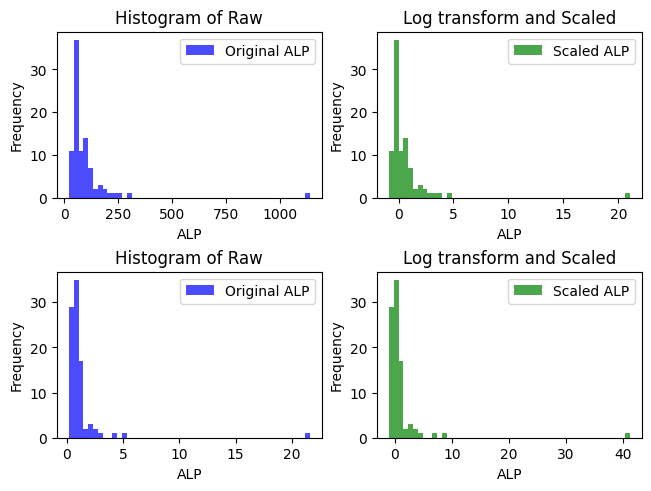

In [ ]:
import matplotlib.pyplot as plt
plt.subplots(constrained_layout=True)
plt.subplot(2, 2, 1)
plt.hist(x_train['ALP'], bins=50, alpha=0.7, color='blue', label='Original ALP')
plt.title('Histogram of Raw')
plt.xlabel('ALP')
plt.ylabel('Frequency')
plt.legend()
plt.subplot(2, 2, 2)
plt.hist(scaled_x_train['ALP'], bins=50, alpha=0.7, color='green', label='Scaled ALP')
plt.title('Log transform and Scaled')
plt.xlabel('ALP')
plt.ylabel('Frequency')
plt.legend()
plt.subplot(2, 2, 3)
plt.hist(x_train['Total Bilirubin'], bins=50, alpha=0.7, color='blue', label='Original ALP')
plt.title('Histogram of Raw')
plt.xlabel('ALP')
plt.ylabel('Frequency')
plt.legend()
plt.subplot(2, 2, 4)
plt.hist(scaled_x_train['Total Bilirubin'], bins=50, alpha=0.7, color='green', label='Scaled ALP')
plt.title('Log transform and Scaled')
plt.xlabel('ALP')
plt.ylabel('Frequency')
plt.legend()

In [ ]:
scaled_x_train

,검체번호,환자번호,검사일,성별,나이,진료과,입원/외래,ALP,ALT,AST,...,prev_ALT,prev_AST,prev_Albumin,prev_BUN,prev_Creatinine,prev_GGT,prev_Glucose,prev_LDH,prev_Total Bilirubin,prev_Total Protein
0,RD2ZPCLEP,0W8BWF8,2024-10-29 11:30:13,2,72,10,1,0.216415,0.143358,0.112959,...,0.165951,0.136782,0.665581,0.324782,0.166498,0.296416,0.447000,0.276738,0.096317,0.455223
1,XXSF8VIJ6,0W8BWF8,2024-10-30 00:27:41,2,72,10,1,0.194523,0.143358,0.182787,...,0.143358,0.112959,0.351472,0.238208,0.062785,0.260741,0.462402,0.184475,0.138718,0.256369
2,ITA5MT9AM,0W8BWF8,2024-10-30 21:41:22,2,72,10,1,0.335702,0.227353,0.287076,...,0.143358,0.182787,0.271302,0.281970,0.117699,0.249055,0.174855,0.247489,0.102708,0.223959
3,ZQC6ZS8KU,16RROYS,2024-10-30 00:54:29,1,70,11,1,0.010149,0.195027,0.164442,...,0.241461,0.182787,0.785875,0.477682,0.250323,0.155473,0.412180,0.138700,0.045371,0.480328
4,Q2VTACCFO,16RROYS,2024-10-31 00:37:07,1,70,11,1,0.000000,0.195027,0.164442,...,0.195027,0.164442,0.696608,0.516431,0.210409,0.144851,0.494106,0.102735,0.091989,0.442401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,EE0QKTNIX,WYZXN21,2024-10-31 23:40:04,1,64,11,1,0.194523,0.117277,0.085638,...,0.143358,0.085638,0.696608,0.099089,0.117699,0.155473,0.378877,0.040817,0.078662,0.416189
88,L6L9YAUMN,X1ULX76,2024-10-30 23:40:22,2,76,14,1,0.461038,0.203706,0.194085,...,0.211961,0.182787,0.096215,0.175717,0.117699,0.121453,0.336048,0.028998,0.363629,0.207302
89,2BOH1B80V,Z5R5522,2024-10-30 01:22:36,1,73,1,1,0.401752,0.312304,0.224372,...,0.351831,0.269647,0.601451,0.802957,0.685398,0.541613,0.209524,0.201626,0.199399,0.492620
90,TV00XW2JW,ZLJRCRA,2024-10-29 22:52:41,2,22,8,1,0.165287,0.000000,0.121243,...,0.000000,0.121243,0.785875,0.281970,0.062785,0.108468,0.180924,0.067492,0.096317,0.540159


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# DNN upgrade
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

sel_str = ['ALP', 'ALT', 'AST',
       'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH',
       'Total Bilirubin', 'Total Protein','prev_ALP', 'prev_ALT', 'prev_AST',
       'prev_Albumin', 'prev_BUN', 'prev_Creatinine', 'prev_GGT',
       'prev_Glucose', 'prev_LDH', 'prev_Total Bilirubin',
       'prev_Total Protein']

tx = x.copy()
# sc = MinMaxScaler()
# tx[['성별','나이','진료과']]=sc.fit_transform(tx[['성별','나이','진료과']])

train_idx, test_idx = next(gss.split(x, groups=x['환자번호']))
x_train = tx.iloc[train_idx].reset_index(drop=True)
x_val = tx.iloc[test_idx].reset_index(drop=True)

x_train,y_train=shuffle_selected_columns_together_df(x_train, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.3, random_state=111)

x_val,y_val=shuffle_selected_columns_together_df(x_val, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.1, random_state=111)

current_columns = ['ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin', 'Total Protein']
prev_columns = [f'prev_{col}' for col in current_columns]
scaled_x_train,scalers=apply_transformation(x_train, current_columns, prev_columns)
scaled_x_val,scalers=apply_transformation(x_val, current_columns, prev_columns)

weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
class_weights = dict(zip(np.array([0, 1]), weights))
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model = []
tf.keras.backend.clear_session()
model = Sequential([
    Dense(256, activation='relu', input_shape=(x_train[sel_str].shape[1],)),  # 첫 번째 은닉층
    Dropout(0.1),  # 과적합 방지
    Dense(256, activation='relu'),  # 두 번째 은닉층
    Dropout(0.1),  # 과적합 방지
    Dense(128, activation='relu'),  # 세 번째 은닉층
    Dropout(0.1),  # 과적합 방지
    Dense(64, activation='relu'),  # 네 번째 은닉층
    Dropout(0.1),  # 과적합 방지
    Dense(32),  # 네 번째 은닉층
    Dense(1, activation='sigmoid')  # 출력층 (이진 분류)
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
            #   metrics=['binary_accuracy'])
              metrics=[tf.keras.metrics.AUC(name='PR', curve='PR'),tf.keras.metrics.AUC(curve='ROC')])

model.fit(scaled_x_train[sel_str].astype(float), y_train, validation_data=(scaled_x_val[sel_str].astype(float), y_val),
          callbacks=[early_stopping_cb],
          class_weight=class_weights,
          epochs=500, batch_size=256, verbose = 2)
y_pred=(model.predict(scaled_x_val[sel_str].astype(float))>0.5).astype(int)

accuracy = accuracy_score(y_val, y_pred)
sensitivity = recall_score(y_val, y_pred)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
specificity = tn / (tn + fp)
f1 = f1_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Balaced Accuracy: {(sensitivity+specificity)/2:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1-Score: {f1:.2f}")


Epoch 1/500
1/1 - 1s - loss: 0.7098 - PR: 0.2474 - auc: 0.4160 - val_loss: 0.7573 - val_PR: 0.2038 - val_auc: 0.8478 - 660ms/epoch - 660ms/step
Epoch 2/500
1/1 - 0s - loss: 0.6586 - PR: 0.5523 - auc: 0.7154 - val_loss: 0.8064 - val_PR: 0.2338 - val_auc: 0.8696 - 26ms/epoch - 26ms/step
Epoch 3/500
1/1 - 0s - loss: 0.6360 - PR: 0.5782 - auc: 0.8177 - val_loss: 0.8510 - val_PR: 0.2338 - val_auc: 0.8696 - 27ms/epoch - 27ms/step
Epoch 4/500
1/1 - 0s - loss: 0.6142 - PR: 0.6444 - auc: 0.8382 - val_loss: 0.8789 - val_PR: 0.2338 - val_auc: 0.8696 - 25ms/epoch - 25ms/step
Epoch 5/500
1/1 - 0s - loss: 0.5971 - PR: 0.6748 - auc: 0.8390 - val_loss: 0.8890 - val_PR: 0.2338 - val_auc: 0.8696 - 27ms/epoch - 27ms/step
Epoch 6/500
1/1 - 0s - loss: 0.5764 - PR: 0.6661 - auc: 0.8442 - val_loss: 0.8778 - val_PR: 0.2338 - val_auc: 0.8696 - 28ms/epoch - 28ms/step
Epoch 7/500
1/1 - 0s - loss: 0.5371 - PR: 0.7813 - auc: 0.8946 - val_loss: 0.8530 - val_PR: 0.2338 - val_auc: 0.8696 - 26ms/epoch - 26ms/step
Epoc

In [ ]:
x_test = pd.read_csv('evaluation_set.csv')
# x_test[['성별','나이','진료과']]=sc.transform(x_test[['성별','나이','진료과']])
scaled_x_test,scalers=apply_transformation(x_test, current_columns, prev_columns)
y_pred = (model.predict(scaled_x_test[sel_str].astype(float))>0.5).astype(int)
evaluate_predictions(y_pred)

4/4 [==============================] - 0s 1ms/step
========EVALUATION RESULTS========
F1 :0.323 BAC : 0.657 PPV (Precision): 0.250
💔 병원이 망했습니다. 더 나은 모델이 필요합니다.


# **5. Hyperparameter + Architecture Tuning**

## **5.1. 하이퍼파라미터 튜닝(Hyperparameter Tuning)**

- **하이퍼파라미터 튜닝**은 머신러닝 모델의 **성능을 최적화**하기 위해 모델이 학습하는 과정에서 설정하는 **파라미터들**을 조정하는 과정입니다. 하이퍼파라미터는 모델이 학습할 때 **사용자가 직접 설정해야 하는 값들**로, 적절히 조정하지 않으면 모델 성능이 낮아질 수 있습니다.

- 하이퍼파라미터 예시

| **모델**   | **주요 하이퍼파라미터**                                                                                   | **특징**                                                                                 |
|------------|-----------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|
| **XGBoost**| `learning_rate`, `max_depth`, `n_estimators`, `subsample`, `colsample_bytree`, `lambda`, `alpha`, `gamma` | 결정 트리 기반. 과적합 방지를 위한 정규화와 샘플링 비율이 중요.                          |
| **DNN**    | `number_of_hidden_layers`, `neurons_per_layer`, `learning_rate`, `dropout_rate`, `activation_function`, `L1/L2 regularization` | 은닉층과 뉴런 수 조정이 중요하며, 정규화를 통해 일반화 성능 향상 가능.                   |
| **CNN**    | `filter_size`, `number_of_filters`, `stride`, `padding`, `pooling_type`, `pool_size`, `number_of_conv_layers` | 이미지, 시계열 데이터 특화. 합성곱층과 풀링층 구조 설계가 성능에 직접적인 영향을 미침. |


### 튜닝 방법
![gridrandomsearch](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/gridrandomsearch-1.png?raw=true)
1. **그리드 서치(Grid Search)**:
   - 그리드 서치는 **모든 하이퍼파라미터의 가능한 값들**을 **조합**하여 가장 좋은 성능을 내는 파라미터를 찾는 방법입니다.
   - 예를 들어, `learning_rate` 값을 0.1, 0.01, 0.001로 시도하고, `max_depth` 값을 3, 5, 7로 시도하여 각 조합을 평가하는 방식입니다.
   - 이 방법은 모든 조합을 테스트트하기 때문에, 파라미터가 많을 경우 계산 시간이 매우 오래 걸려 비효율적입니다.

2. **랜덤 서치(Random Search)**:
   - 그리드 서치와 달리, **하이퍼파라미터를 랜덤으로 선택**하여 최적의 값을 찾는 방법입니다. 모든 조합을 시도하지 않기 때문에 속도가 더 빠르지만, **최적의 조합을 놓칠 수** 있습니다.
   
3. **베이지안 최적화(Bayesian Optimization)**:
   - 이전 실험에서 얻은 결과를 바탕으로 다음 실험에 사용할 하이퍼파라미터 값을 결정하는 방식으로, 점진적으로 최적의 하이퍼파라미터를 찾습니다. 탐색 공간의 확률 모델을 생성하여 기대값이 최대화되는 지점을 샘플링하는 원리입니다.
   

### **베이지안 최적화 (내용 축소 명확히 )**

베이지안 최적화의 핵심은 **Surrogate Model**과 **Acquisition Function**을 사용하는 것입니다.

1. Surrogate Model

Surrogate Model은 목표 함수( $f(x)$ )의 실제 계산을 대신해 확률적인 추정을 제공하는 모델입니다. 이는 실제 목적 함수 $f(x)$ 를 평가하는 데 필요한 비용을 줄이기 위해 사용됩니다.

![alt text](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/bayesian1-1.png?raw=true)![alt text](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/bayesian6-1.png?raw=true)

입력값 $(x1, f(x1)), (x2, f(x2)), ... , (xt, f(xt))$ 라는 이미 수집된 데이터를 바탕으로, 실제 목표 함수 $f(x)$ 에 대한 확률적인 추정을 합니다.
즉, 실제로 계산할 수 없는 함수의 형태를 예측하는 역할을 합니다.

예시: 하이퍼파라미터 집합과 그에 대응하는 일반화 성능을 모델링한 결과로 생각할 수 있습니다. 이 모델을 통해 하이퍼파라미터의 변화에 따른 성능 변화를 예측할 수 있습니다.

2. Acquisition Function

![alt text](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/bayesian2-1.png?raw=true)

Acquisition Function은 Surrogate Model의 예측을 바탕으로 다음 탐색할 입력값을 추천하는 함수입니다. 이를 통해 다음 실험을 설계하여 최적값에 가까운 하이퍼파라미터를 찾습니다.

![alt text](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/bayesian3-1.png?raw=true)

Surrogate Model이 예측한 목표 함수의 추정을 바탕으로, 최적값일 가능성이 높은 값과 불확실성이 큰 값을 구분해 추천합니다.

- 최적값일 가능성이 높은 값: Surrogate Model에서 함수값이 높은 곳.

- 불확실성이 큰 값: Surrogate Model에서 표준편차가 큰 곳.

![alt text](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/bayesian4-1.png?raw=true)

예시: 다음에 탐색할 하이퍼파라미터 집합을 결정하는 데 사용됩니다. Acquisition Function은 실험을 반복하며 모델의 성능을 개선할 가능성이 높은 하이퍼파라미터를 선택합니다.
    
![alt text](https://github.com/dlab-amc/DLab-TG-AI/blob/main/images/bayesian5-1.png?raw=true)

=> **검은 점선**은 실제 목적 함수, **검은 실선**은 추정한 목적함수(Surrogate Model)를 의미합니다. 파란 영역은 추정된 $σ(x)$, 하단 녹색 실선은 Acquistition Function을 의미합니다.

**Bayesian Optimization의 작동 원리**

1. 초기 하이퍼파라미터 집합과 성능 수집:
    - 초기 하이퍼파라미터 집합에 대해 목표 함수의 성능을 평가하고, 이를 Surrogate Model에 입력하여 모델링합니다.
2. Acquisition Function을 통해 새로운 후보 찾기:
    - Surrogate Model을 통해 예측된 정보를 바탕으로 Acquisition Function을 사용하여 다음 탐색할 하이퍼파라미터를 추천합니다.
3. 다음 실험 수행:
    - 추천된 하이퍼파라미터 집합을 사용하여 실제로 모델을 학습하고 성능을 측정합니다. 이 결과는 새로운 데이터로 추가됩니다.
4. 모델 업데이트:
    - 새로 수집된 하이퍼파라미터 집합과 성능 정보를 Surrogate Model에 업데이트하여, 더 정교한 예측을 할 수 있도록 합니다.
5. 반복:
    - 이 과정을 반복하면서 점점 더 최적의 하이퍼파라미터 집합을 찾아냅니다.



### Optuna란?

**Optuna**는 **하이퍼파라미터 튜닝을 자동화**하는 라이브러리로, **효율적이고 빠른 방법**으로 최적의 하이퍼파라미터를 찾을 수 있게 도와줍니다. Optuna는 베이지안 최적화를 기반으로 하여 **최소화/최대화하려는 목표 함수**를 효율적으로 탐색합니다. 주로 머신러닝 모델을 학습할 때 하이퍼파라미터를 최적화하는 데 사용됩니다.

### Optuna 사용 방법:

1. **목표 함수 정의**:
   - Optuna는 **목표 함수(objective function)** 를 최적화합니다. 이 함수는 하이퍼파라미터를 입력받아, 모델의 성능을 평가한 후 그 결과를 반환합니다.
   
2. **검색 공간 설정**:
   - 튜닝할 하이퍼파라미터와 그 값들의 범위를 설정합니다.

3. **Optuna 최적화 실행**:
   - Optuna가 여러 번의 실험을 실행하면서 각 하이퍼파라미터 조합에 대한 성능을 평가하고, 최적의 값을 찾아냅니다.

### 코드 예제 (Tuning Pipeline)

1. objective Function안에 모델 학습과정을 Wraping하고 Metric을 반환합니다.
2. trial object를 이용해 HyperParmater를 Suggest합니다.(Sampling)
3. study object를 만들고 Optimization을 실행합니다.


```python
    import optuna

    def objective(trial):
        x = trial.suggest_float('x', -10, 10)
        return (x - 2) ** 2

    study = optuna.create_study()
    study.optimize(objective, n_trials=100)
    study.best_params  # E.g. {'x': 2.002108042}
```

<br>
-10~ 10 사이의 Float를 파라미터($x$) 범위로 정의하고, $(x-2)**2$ 이 최소가 될 수 있도록 최적화하는 함수의 예시입니다.

파라미터의 범위는 objective 함수 안에서 입력된 trial method를 이용해 지정할 수 있습니다. 파라미터의 특성에 맞게 suggest method를 고르면 됩니다.

- 대표적인 suggest method
    - suggest_categorical(name, choices)
    - suggest_float(name, low, high, *, step=None, log=False)
    - suggest_int(name, low, high, step=1, log=False)

In [ ]:
def hp_xgb(trial, y_train):
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    param = {
        'scale_pos_weight': class_weights[1]/class_weights[0],
        'objective': 'binary:logistic',  # 이진 분류 (0 또는 1로 분류)
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),  # 부스팅 방법 선택 ('gbtree' 또는 'dart')
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),  # L2 정규화 계수 (모델의 과적합을 방지)
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),  # L1 정규화 계수 (모델의 과적합을 방지)
        'learning_rate': trial.suggest_categorical('lr', [0.01, 0.005, 0.001,0.0001]),  # 학습률 (모델을 학습할 때 얼마나 빨리 업데이트할지 결정)
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),  # 데이터 샘플링 비율 (모델이 학습에 사용할 데이터의 비율)
        'max_depth': trial.suggest_int('max_depth', 2, 40),  # 트리의 최대 깊이 (트리 모델의 복잡도를 결정)
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 40),  # 리프 노드에 최소한 있어야 할 샘플의 수
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, step=10),  # 트리의 개수
        'tree_method': 'gpu_hist',  # GPU를 이용한 트리 학습 방법
        'predictor': 'gpu_predictor',  # GPU에서 예측을 빠르게 하기 위한 설정
        # 'gpu_id': -1,  # 사용할 GPU를 지정 (여기서는 -1로 설정하여 GPU를 사용하지 않음)
        'eval_metric': 'aucpr',
        'early_stopping_rounds' : 100,
    }
    model = xgb.XGBClassifier(**param) # 위에서 설정한 하이퍼파라미터를 바탕으로 XGBoost 모델을 생성
    return model

def hp_dnn(trial, input_dim):
    num_layers = trial.suggest_int('num_layers', 2, 10)  # DNN의 은닉층 개수를 2~10 사이에서 탐색
    activ_fcn = trial.suggest_categorical('dense_activation', ['relu', 'elu', 'gelu']) # 은닉층에서 사용할 활성화 함수를 'relu', 'elu', 'gelu' 중 선택
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam','Nadam']) # 최적화 알고리즘을 'Adam' 또는 'Nadam' 중에서 선택
    lr = trial.suggest_categorical('lr', [0.001, 0.005, 0.0005]) # 학습률(learning rate)을 세 가지 고정값 중에서 선택
    input_tensor = tf.keras.layers.Input(shape=(input_dim,)) # 입력 텐서 정의. 입력 데이터는 1D 벡터로 처리됨
    x = input_tensor
    for i in range(num_layers):
        units = trial.suggest_int(name='units_' + str(i), low=16, high=512, step=16)  # 각 은닉층의 뉴런 수를 16에서 512까지 16 단위로 탐색
        # 은닉층(Dense Layer)을 추가. 샘플링된 뉴런 수, 활성화 함수, 가중치 초기화 방식 사용
        # 가중치 초기화 방식: 'he_normal', 'glorot_uniform', 'lecun_normal' 중 선택
        x = tf.keras.layers.Dense(units=units, activation=activ_fcn,
                                  kernel_initializer=trial.suggest_categorical('kernel_initializer_' + str(i), ['he_normal', 'glorot_uniform', 'lecun_normal']))(x)
        batch_norm = trial.suggest_categorical('batch_' + str(i), [True, False]) # 배치 정규화(Batch Normalization) 적용 여부를 True/False로 결정
        if batch_norm:
            x = tf.keras.layers.BatchNormalization()(x) # 배치 정규화를 추가해 학습 안정성을 높임
        dropout = trial.suggest_categorical('dropout_' + str(i), [True, False]) # 드롭아웃 적용 여부를 True/False로 결정
        if dropout:
            dropout_rate = trial.suggest_float('dropout_rate_' + str(i), 0.1, 0.5, step=0.1)  # 드롭아웃 비율을 0.1~0.5 사이에서 0.1 단위로 탐색
            x = tf.keras.layers.Dropout(dropout_rate)(x) # 드롭아웃 레이어 추가
        l2_reg = trial.suggest_float('l2_reg_' + str(i), 1e-6, 1e-1, log=True) # L2 정규화 강도를 로그 스케일로 1e-6에서 1e-1 사이에서 탐색
        x = tf.keras.layers.Dense(units=units, activation=activ_fcn,
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x) # 은닉층(Dense Layer)에 L2 정규화를 적용
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # 출력층. 이진 분류를 위한 시그모이드 활성화 함수 사용
    model = tf.keras.Model(inputs=input_tensor, outputs=x) # 입력 텐서와 출력 텐서를 연결해 모델 정의
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'Nadam':
        optimizer = Nadam(learning_rate=lr)
    # else:  # RMSprop
    #     optimizer = RMSprop(learning_rate=lr)
    model.compile(loss='binary_crossentropy', # 손실 함수: 이진 교차 엔트로피(binary_crossentropy)
                  optimizer=optimizer,
                  metrics=[tf.keras.metrics.AUC(name='PR', curve='PR'),
                           tf.keras.metrics.BinaryAccuracy(name='bacc', threshold=0.5),
                           tf.keras.metrics.AUC(curve='ROC')])
    return model

In [ ]:
import optuna
#!pip install optuna

sel_str = ['성별','나이','진료과','입원/외래','ALP', 'ALT', 'AST',
       'Albumin', 'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH',
       'Total Bilirubin', 'Total Protein','prev_ALP', 'prev_ALT', 'prev_AST',
       'prev_Albumin', 'prev_BUN', 'prev_Creatinine', 'prev_GGT',
       'prev_Glucose', 'prev_LDH', 'prev_Total Bilirubin',
       'prev_Total Protein']

# insilico simulation
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, test_idx = next(gss.split(x, groups=x['환자번호']))
x_train = x.iloc[train_idx].reset_index(drop=True)
x_val = x.iloc[test_idx].reset_index(drop=True)

x_train,y_train=shuffle_selected_columns_together_df(x_train, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.2, random_state=111)

x_val,y_val=shuffle_selected_columns_together_df(x_val, ['ALP', 'ALT', 'AST', 'Albumin',
       'BUN', 'Creatinine', 'GGT', 'Glucose', 'LDH', 'Total Bilirubin',
       'Total Protein'], shuffle_ratio=0.1, random_state=111)

# HP tuning ----------------------
def objective(trial):
    model = []
    model = hp_xgb(trial,y_train)
    model.fit(x_train[sel_str], y_train,
          eval_set = [(x_train[sel_str],y_train), (x_val[sel_str],y_val)])
    preds = (model.predict_proba(x_val[sel_str])[:, 1] > 0.5).astype(int)    # print('AUROC : ', roc_auc_score(y_val, preds[:,1]))
    return f1_score(y_val, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 5, show_progress_bar=True)

[I 2024-12-04 04:14:16,222] A new study created in memory with name: no-name-f216a72c-a463-4669-9c2e-f7393129460f
  0%|          | 0/5 [00:00<?, ?it/s]

[0]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[1]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[2]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[3]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[4]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[5]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[6]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[7]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[8]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[9]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[10]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[11]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[12]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[13]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[14]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[15]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[16]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[17]	va

Best trial: 0. Best value: 0:   0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-12-04 04:14:16,763] Trial 0 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 0.00015828161382171223, 'alpha': 0.0033663448207894853, 'lr': 0.005, 'subsample': 0.8841967123193633, 'max_depth': 24, 'min_child_weight': 21, 'n_estimators': 430}. Best is trial 0 with value: 0.0.


Best trial: 0. Best value: 0:  20%|██        | 1/5 [00:00<00:02,  1.83it/s]

[0]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[1]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[2]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[3]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[4]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[5]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[6]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[7]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[8]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[9]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[10]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[11]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[12]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[13]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[14]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[15]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[16]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[17]	va

Best trial: 0. Best value: 0:  40%|████      | 2/5 [00:00<00:01,  2.74it/s]

[I 2024-12-04 04:14:17,005] Trial 1 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 0.20139381981681304, 'alpha': 0.061712236531573254, 'lr': 0.001, 'subsample': 0.9644495619828438, 'max_depth': 36, 'min_child_weight': 22, 'n_estimators': 60}. Best is trial 0 with value: 0.0.
[0]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[1]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[2]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[3]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[4]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[5]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[6]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[7]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[8]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[9]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[10]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[11]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000


Best trial: 0. Best value: 0:  60%|██████    | 3/5 [00:01<00:00,  2.77it/s]

[I 2024-12-04 04:14:17,361] Trial 2 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 1.879923508447922e-05, 'alpha': 5.2165798620607875e-06, 'lr': 0.01, 'subsample': 0.989772877263325, 'max_depth': 35, 'min_child_weight': 27, 'n_estimators': 520}. Best is trial 0 with value: 0.0.
[0]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[1]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[2]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[3]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[4]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[5]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[6]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[7]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[8]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[9]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[10]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[11]	validation_0-aucpr:0.19565	validation_1-aucpr:0.080

Best trial: 0. Best value: 0:  80%|████████  | 4/5 [00:06<00:02,  2.30s/it]

[I 2024-12-04 04:14:22,638] Trial 3 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 1.5268413334346493e-05, 'alpha': 0.1081426936389628, 'lr': 0.005, 'subsample': 0.8775433523406926, 'max_depth': 34, 'min_child_weight': 34, 'n_estimators': 110}. Best is trial 0 with value: 0.0.
[0]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[1]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[2]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[3]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[4]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[5]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[6]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[7]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[8]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[9]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[10]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[11]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000


Best trial: 0. Best value: 0: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]

[I 2024-12-04 04:14:22,977] Trial 4 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 1.2322462018543626e-07, 'alpha': 1.8295042010059082e-06, 'lr': 0.0001, 'subsample': 0.8478205865930197, 'max_depth': 36, 'min_child_weight': 20, 'n_estimators': 290}. Best is trial 0 with value: 0.0.


In [ ]:
# model training ----------------------
best_trial=study.best_trial
best_model=hp_xgb(best_trial,y_train)
best_model.fit(x_train[sel_str], y_train,
                 eval_set=[(x_train[sel_str], y_train), (x_val[sel_str], y_val)])

[0]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[1]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[2]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[3]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[4]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[5]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[6]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[7]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[8]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[9]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[10]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[11]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[12]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[13]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[14]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[15]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[16]	validation_0-aucpr:0.19565	validation_1-aucpr:0.08000
[17]	va

XGBClassifier(alpha=0.0033663448207894853, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.00015828161382171223,
              learning_rate=0.005, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=24,
              max_leaves=None, min_child_weight=21, missing=nan,
              monotone_constraints=None, n_estimators=430, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# XGB testing
y_pred  = best_model.predict(x_val[sel_str])
y_pred_probs = best_model.predict_proba(x_val[sel_str])[:,1]
# 민감도(Recall) 계산
sensitivity = recall_score(y_val, y_pred)
# 특이도 계산
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
specificity = tn / (tn + fp)

# F1-score 계산
f1 = f1_score(y_val, y_pred)

print(f"Balaced Accuracy: {(sensitivity+specificity)/2:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"F1-Score: {f1:.3f}")

Balaced Accuracy: 0.500
Sensitivity: 0.000
Specificity: 1.000
F1-Score: 0.000
